# Tasks

### Install packages

In [3]:
!pip install mpl_tools scikit-learn matplotlib seaborn conllu seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=806158eff90f1145551530744d0e022d1281e5b19f23802f34ad52ad6cf6f67d
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


## 1. Dataset Exploration

In [4]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os, requests # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

### Load the Dataset

In [5]:
# Optional: Auto-download UD English EWT r2.14 from official repo
# If you already have the Kaggle files, skip this cell.

DATA_DIR = Path('data/ud_en')
DATA_DIR.mkdir(parents=True, exist_ok=True)

base = 'https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/r2.14'
files = {
    'train.conllu': 'en_ewt-ud-train.conllu',
    'dev.conllu':   'en_ewt-ud-dev.conllu',
    'test.conllu':  'en_ewt-ud-test.conllu',
}

for out_name, src_name in files.items():
    out_path = DATA_DIR/out_name
    if not out_path.exists():
        url = f"{base}/{src_name}"
        print('Downloading', url)
        r = requests.get(url)
        r.raise_for_status()
        out_path.write_bytes(r.content)

print('Data files present:', list(DATA_DIR.iterdir()))


Data files present: [PosixPath('data/ud_en/train.conllu'), PosixPath('data/ud_en/test.conllu'), PosixPath('data/ud_en/dev.conllu')]


In [6]:
# Basic stats and samples from UD English EWT dataset

from conllu import parse_incr
from pathlib import Path
from collections import Counter
import random

DATA_DIR = Path('data/ud_en')
TRAIN = DATA_DIR/'train.conllu'
DEV   = DATA_DIR/'dev.conllu'
TEST  = DATA_DIR/'test.conllu'
assert TRAIN.exists() and DEV.exists() and TEST.exists(), 'Missing .conllu files in data/ud_en/'


def read_conllu(path):
    with open(path, 'r', encoding='utf-8') as f:
        for sent in parse_incr(f):
            tokens = [t['form'] for t in sent if isinstance(t['id'], int)]
            tags   = [t['upostag'] for t in sent if isinstance(t['id'], int)]
            yield tokens, tags

train = list(read_conllu(TRAIN))
dev   = list(read_conllu(DEV))
test  = list(read_conllu(TEST))

len_train, len_dev, len_test = len(train), len(dev), len(test)
print(f"Number of sentences (train) : {len_train}")
print(f"Number of sentences (dev) : {len_dev}")
print(f"Number of sentences (test) : {len_test}")

Number of sentences (train) : 12544
Number of sentences (dev) : 2001
Number of sentences (test) : 2077


### Analyze

#### Number of sentences and tokens

In [7]:
all_sents = train + dev + test
num_sentences = len(all_sents)
num_tokens = sum(len(s[0]) for s in all_sents)
avg_len = num_tokens / num_sentences

print(f"Total sentences: {num_sentences}")
print(f"Total tokens: {num_tokens}")


Total sentences: 16622
Total tokens: 254821


#### POS tag distribution

Convert the data into a suitable format for training a sequence labeling model (POS tagging)

In [8]:
tag_counter = Counter(tag for _, tags in all_sents for tag in tags)

for tag, c in tag_counter.most_common(20):
    print(f"{tag:>5}: {c}")

 NOUN: 43156
PUNCT: 29768
 VERB: 27890
 PRON: 23044
  ADP: 21866
  DET: 20098
  ADJ: 16812
PROPN: 16563
  AUX: 15924
  ADV: 12507
CCONJ: 8204
 PART: 7044
  NUM: 5052
SCONJ: 4603
 INTJ: 930
  SYM: 913
    X: 447


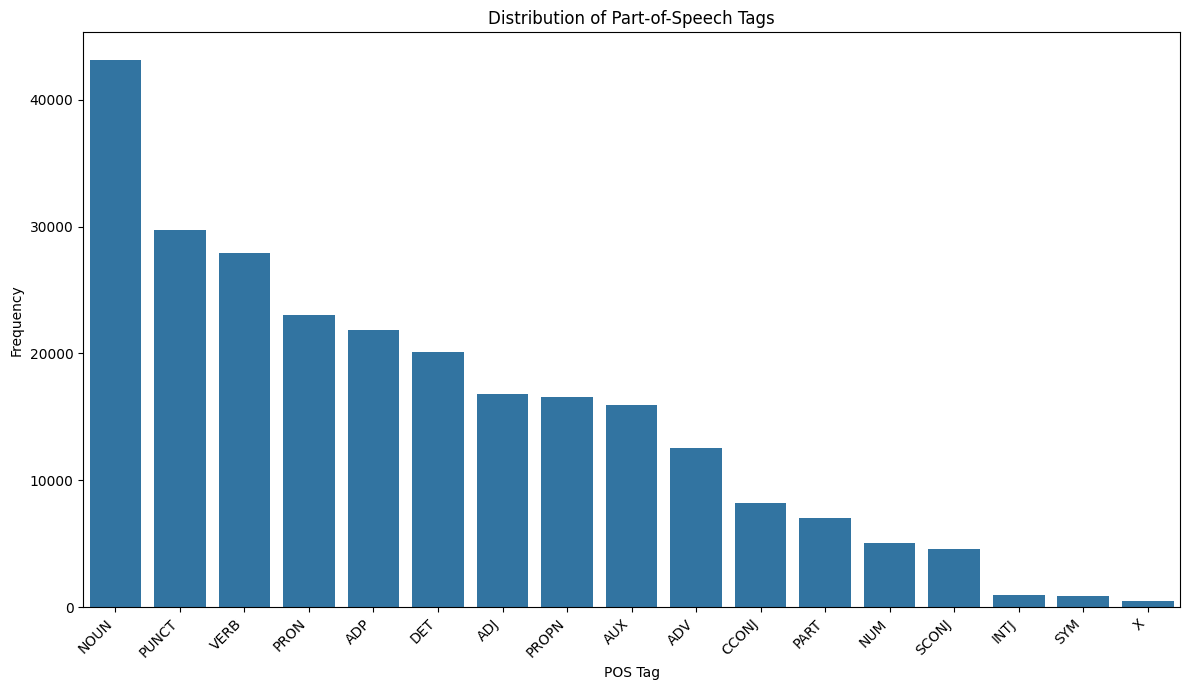

In [9]:
import pandas as pd
import seaborn as sns

# Convert the tag_counter to a DataFrame for easier plotting
tag_df = pd.DataFrame(tag_counter.most_common(), columns=['Tag', 'Count'])

plt.figure(figsize=(12, 7))
sns.barplot(x='Tag', y='Count', data=tag_df)
plt.title('Distribution of Part-of-Speech Tags')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Average sentence lengths

In [10]:
print(f"Average sentence length: {avg_len:.2f}")

Average sentence length: 15.33


### Sample

In [11]:
print("Tokens with UPOS tags for five random sentences:")
for num in range(5):
    tokenSentence, tagSentence = random.choice(all_sents)
    print(f"Random Sentence {num+1}:",end="\n")
    for token, tag in zip(tokenSentence, tagSentence):
        print(f"{token} [{tag}]",end=" ")
    print("\n")


Tokens with UPOS tags for five random sentences:
Random Sentence 1:
- [PUNCT] it [PRON] dries [VERB] out [ADP] , [PUNCT] losing [VERB] the [DET] water [NOUN] that [PRON] is [AUX] soaked [VERB] into [ADP] the [DET] set [ADJ] structure [NOUN] 

Random Sentence 2:
This [DET] place [NOUN] has [AUX] done [VERB] a [DET] great [ADJ] job [NOUN] of [SCONJ] taking [VERB] care [NOUN] of [ADP] the [DET] usual [ADJ] maintenance [NOUN] on [ADP] my [PRON] hooptie [NOUN] . [PUNCT] 

Random Sentence 3:
Again [ADV] , [PUNCT] congratulations [NOUN] . [PUNCT] 

Random Sentence 4:
I [PRON] ordered [VERB] the [DET] MOO [NOUN] SHU [NOUN] pork [NOUN] and [CCONJ] it [PRON] was [AUX] great [ADJ] .. [PUNCT] 

Random Sentence 5:
email [VERB] them [PRON] at [ADP] address [NOUN] below [ADV] 



In [12]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from seqeval.metrics import classification_report, accuracy_score, f1_score

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'


def build_vocab(sentences, min_freq=1):
    wc = Counter(tok.lower() for toks, _ in sentences for tok in toks)
    itos = [PAD_TOKEN, UNK_TOKEN] + [w for w, c in wc.items() if c >= min_freq]
    stoi = {w:i for i, w in enumerate(itos)}
    return stoi, itos


def build_tag_map(sentences):
    tags = sorted({t for _, ts in sentences for t in ts})
    tag2id = {t:i for i, t in enumerate(tags)}
    id2tag = {i:t for t, i in tag2id.items()}
    return tag2id, id2tag


word2id, id2word = build_vocab(train)
tag2id, id2tag   = build_tag_map(train)
PAD_ID = word2id[PAD_TOKEN]


MAX_LEN = 128


def vectorize(tokens, tags=None, max_len=MAX_LEN):
    ids = [word2id.get(tok.lower(), word2id[UNK_TOKEN]) for tok in tokens]
    tids = None
    if tags is not None:
        tids = [tag2id[t] for t in tags]
    if max_len is not None:
        ids = ids[:max_len]
        if tids is not None:
            tids = tids[:max_len]
    return ids, tids


class SeqDataset(Dataset):
    def __init__(self, samples, max_len=MAX_LEN):
        self.samples = samples
        self.max_len = max_len
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        tokens, tags = self.samples[idx]
        wi, ti = vectorize(tokens, tags, self.max_len)
        return wi, ti


def collate(batch):
    xs, ys = zip(*batch)
    max_len = max(len(x) for x in xs)
    px = [x + [PAD_ID]*(max_len-len(x)) for x in xs]
    py = [y + [-100]*(max_len-len(y)) for y in ys]  # -100 ignored in CrossEntropyLoss
    attn = [[1]*len(x) + [0]*(max_len-len(x)) for x in xs]
    return (torch.tensor(px, dtype=torch.long),
            torch.tensor(py, dtype=torch.long),
            torch.tensor(attn, dtype=torch.bool))


train_dl = DataLoader(SeqDataset(train), batch_size=64, shuffle=True, collate_fn=collate)
dev_dl   = DataLoader(SeqDataset(dev),   batch_size=128, shuffle=False, collate_fn=collate)
test_dl  = DataLoader(SeqDataset(test),  batch_size=128, shuffle=False, collate_fn=collate)


def evaluate_sequences(true_ids, pred_ids):
    all_true, all_pred = [], []
    for y, p in zip(true_ids, pred_ids):
        y_tags = [id2tag[i] for i in y]
        p_tags = [id2tag[i] for i in p]
        all_true.append(y_tags)
        all_pred.append(p_tags)
    acc = accuracy_score(all_true, all_pred)
    macro_f1 = f1_score(all_true, all_pred, average='macro')
    micro_f1 = f1_score(all_true, all_pred, average='micro')
    report = classification_report(all_true, all_pred, digits=4)
    return acc, macro_f1, micro_f1, report


## Baseline POS tagger

In [13]:
import os, random, statistics, math
from collections import Counter
import numpy as np
import torch

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [14]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, num_tags, emb_dim=100, hidden_dim=256, num_layers=1, dropout=0.2, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hidden_dim//2, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers>1 else 0,
                            bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_tags)

    def forward(self, x, mask=None):
        e = self.emb(x)                     # (B, T, E)
        out, _ = self.lstm(e)               # (B, T, H)
        out = self.dropout(out)
        logits = self.fc(out)               # (B, T, C)
        return logits


def train_epoch(model, dl, optimizer, criterion):
    model.train()
    total = 0.0
    for X, Y, M in dl:
        X, Y, M = X.to(device), Y.to(device), M.to(device)
        optimizer.zero_grad()
        logits = model(X, M)
        loss = criterion(logits.view(-1, logits.size(-1)), Y.view(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item()
    return total / max(1, len(dl))

@torch.no_grad()
def evaluate_model(model, dl):
    model.eval()
    all_true, all_pred = [], []
    for X, Y, M in dl:
        X, Y, M = X.to(device), Y.to(device), M.to(device)
        logits = model(X, M)
        pred = logits.argmax(-1)
        for y, p, m in zip(Y, pred, M):
            y = y[m].tolist()
            p = p[m].tolist()
            all_true.append(y)
            all_pred.append(p)
    acc, macro_f1, micro_f1, report = evaluate_sequences(all_true, all_pred)
    return acc, macro_f1, micro_f1, report

### Train Baseline POS Tagger

In [15]:
model_baseline = BiLSTMTagger(vocab_size=len(id2word), num_tags=len(tag2id), pad_idx=PAD_ID).to(device)
optimizer = torch.optim.AdamW(model_baseline.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

EPOCHS = 8
for epoch in range(EPOCHS):
    tr_loss = train_epoch(model_baseline, train_dl, optimizer, criterion)
    accuracy, mF1, uF1, report = evaluate_model(model_baseline, dev_dl)
    print(f"Epoch {epoch+1:02d} | train_loss={tr_loss:.4f} | dev_acc={accuracy:.4f} | dev_macroF1={mF1:.4f}")

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DET seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROPN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NOUN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171:

Epoch 01 | train_loss=0.7788 | dev_acc=0.8528 | dev_macroF1=0.7445
Epoch 02 | train_loss=0.3002 | dev_acc=0.8978 | dev_macroF1=0.7941
Epoch 03 | train_loss=0.1794 | dev_acc=0.8990 | dev_macroF1=0.8034
Epoch 04 | train_loss=0.1110 | dev_acc=0.9037 | dev_macroF1=0.8080
Epoch 05 | train_loss=0.0680 | dev_acc=0.9077 | dev_macroF1=0.8154
Epoch 06 | train_loss=0.0424 | dev_acc=0.9096 | dev_macroF1=0.8228
Epoch 07 | train_loss=0.0283 | dev_acc=0.9079 | dev_macroF1=0.8194
Epoch 08 | train_loss=0.0185 | dev_acc=0.9065 | dev_macroF1=0.8198


### Train accuracy

In [16]:
print(f"Dev Accuracy : {100*accuracy:.3} %")
print(f"Dev report (Baseline): {report}")

Dev Accuracy : 90.7 %
Dev report (Baseline):               precision    recall  f1-score   support

         ART     0.9710    0.9320    0.9511       647
        CONJ     0.9618    0.9321    0.9467      1163
          DJ     0.9038    0.8325    0.8667      1761
          DP     0.9243    0.9554    0.9396      1994
          DV     0.6511    0.8219    0.7266      1106
         ERB     0.9287    0.8878    0.9078      2656
          ET     0.9815    0.9867    0.9841      1879
         NTJ     0.9167    0.6875    0.7857       112
         OUN     0.8418    0.8332    0.8375      3711
         RON     0.9742    0.9823    0.9782      2150
        ROPN     0.6609    0.5934    0.6253      1419
          UM     0.7763    0.8310    0.8027       355
        UNCT     0.9305    0.9776    0.9535      2945
          UX     0.9834    0.9766    0.9800      1455
          YM     0.8082    0.7108    0.7564        83
           _     0.1250    0.0526    0.0741        19

   micro avg     0.8935    0.8935  

### Test accuracy

In [17]:
test_accuracy, mF1_t, uF1_t, test_report = evaluate_model(model_baseline, test_dl)
print(f"Test Accuracy: {test_accuracy*100:.3} %")
print("Test Report (Baseline):", test_report)

Test Accuracy: 90.7 %
Test Report (Baseline):               precision    recall  f1-score   support

         ART     0.9686    0.9550    0.9617       645
        CONJ     0.9675    0.9396    0.9533      1109
          DJ     0.9021    0.8323    0.8658      1694
          DP     0.9316    0.9548    0.9431      1969
          DV     0.6645    0.8599    0.7497      1078
         ERB     0.9306    0.9027    0.9164      2569
          ET     0.9919    0.9845    0.9882      1874
         NTJ     0.9400    0.7966    0.8624       118
         OUN     0.8326    0.8284    0.8305      3578
         RON     0.9740    0.9905    0.9822      2114
        ROPN     0.6566    0.5999    0.6270      1562
          UM     0.7957    0.7480    0.7711       500
        UNCT     0.9211    0.9798    0.9495      2967
          UX     0.9872    0.9796    0.9834      1422
          YM     0.8273    0.8349    0.8311       109
           _     0.0000    0.0000    0.0000        16

   micro avg     0.8919    0.8958 

## 3. Contextual Embedding-Based POS Tagger (BERT)

In [18]:
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification, DataCollatorForTokenClassification,
    TrainingArguments, Trainer
)
from seqeval.metrics import (
    accuracy_score,
    classification_report,
    f1_score)


### Preprocess and encode

In [23]:
class HFTokenDataset(torch.utils.data.Dataset):
    def __init__(self, enc):
        self.enc = enc
    def __len__(self): return len(self.enc['input_ids'])
    def __getitem__(self, idx):
        return {k: torch.tensor(v[idx]) for k,v in self.enc.items()}

# convert it into hugging face dict
def to_hf_dict(sentences):
    return {"tokens":[text for text, _ in sentences], "tags":[u for _, u in sentences]}


# Create mappings between label and ids
label_list = [id2tag[i] for i in range(len(id2tag))]
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}

# This function tokenizes input sequences and aligns their corresponding labels (POS tags)
# for use with Hugging Face token classification models. It handles subword tokenization
# by assigning the original label to the first subword token and -100 to subsequent
# subword tokens and special tokens, which tells the model to ignore them during loss computation.
def encode_dataset(data, tokenizer):
    encoded = tokenizer(data['tokens'], is_split_into_words=True, truncation=True, padding=False, max_length=128)
    all_labels = []
    for i in range(len(data['tokens'])):
        word_ids = encoded.word_ids(batch_index=i)
        labels = data['tags'][i]
        aligned = []
        prev_word_id = None
        for word_id in word_ids:
            if word_id is None:
                aligned.append(-100)
            else:
                if word_id != prev_word_id:
                    aligned.append(label2id[labels[word_id]])
                else:
                    aligned.append(-100)
                prev_word_id = word_id
        all_labels.append(aligned)
    encoded['labels'] = all_labels
    return encoded

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    true_seqs, pred_seqs = [], []
    for p, l in zip(preds, labels):
        y, yh = [], []
        for pi, li in zip(p, l):
            if li != -100:
                y.append(id2label[int(li)])
                yh.append(id2label[int(pi)])
        true_seqs.append(y)
        pred_seqs.append(yh)
    return {"accuracy": accuracy_score(true_seqs, pred_seqs)}

In [24]:
# Use bert based tokenizer
MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_hf, dev_hf, test_hf = to_hf_dict(train), to_hf_dict(dev), to_hf_dict(test)

train_encoder = encode_dataset(train_hf, tokenizer)
dev_encoder   = encode_dataset(dev_hf, tokenizer)
test_encoder  = encode_dataset(test_hf, tokenizer)

# Create dataset in hugging face format suitable for transformers
train_ds = HFTokenDataset(train_encoder)
dev_ds   = HFTokenDataset(dev_encoder)
test_ds  = HFTokenDataset(test_encoder)

### Initialize BERT model

In [25]:
# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Classifier
model_ctx = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
).to(device)

# Training args
args = TrainingArguments(
    output_dir='outputs/bert-pos',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=50,
    fp16=torch.cuda.is_available(),
    report_to=[]
)

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForTokenClassification LOAD REPORT from: bert-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.pooler.dense.weight                   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
bert.pooler.dense.bias                     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized beca

### Train BERT classifier

In [26]:
trainer = Trainer(
    model=model_ctx,
    args=args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.081783,0.104359,0.970774
2,0.038550,0.100049,0.974194
3,0.018588,0.110350,0.975188
4,0.005969,0.122496,0.975426


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=3136, training_loss=0.059631151783907294, metrics={'train_runtime': 351.063, 'train_samples_per_second': 142.926, 'train_steps_per_second': 8.933, 'total_flos': 1377441152226336.0, 'train_loss': 0.059631151783907294, 'epoch': 4.0})

### Evaluate

#### Train metrics

In [27]:
metrics_dev = trainer.evaluate()
print('Dev metrics:', metrics_dev)

Dev metrics: {'eval_loss': 0.1224958524107933, 'eval_accuracy': 0.9754264583084814, 'eval_runtime': 1.7678, 'eval_samples_per_second': 1131.898, 'eval_steps_per_second': 35.637, 'epoch': 4.0}


Test metrics

In [28]:
pred_output = trainer.predict(test_ds)
logits = pred_output.predictions
labels = pred_output.label_ids
preds = np.argmax(logits, axis=-1)

true_seqs, pred_seqs = [], []
for p, l in zip(preds, labels):
    y, yh = [], []
    for pi, li in zip(p, l):
        if li != -100:
            y.append(id2label[int(li)])
            yh.append(id2label[int(pi)])
    true_seqs.append(y)
    pred_seqs.append(yh)

print('BERT Test Accuracy:', accuracy_score(true_seqs, pred_seqs))
print('BERT Test macro-F1:', f1_score(true_seqs, pred_seqs, average='macro'))
print('BERT Test micro-F1:', f1_score(true_seqs, pred_seqs, average='micro'))
print('BERT TEST REPORT:', classification_report(true_seqs, pred_seqs, digits=4))


BERT Test Accuracy: 0.97561170000797
BERT Test macro-F1: 0.9121620714770449


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PRON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: SCONJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROPN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:17

BERT Test micro-F1: 0.9707997944853572
BERT TEST REPORT:               precision    recall  f1-score   support

         ART     0.9984    0.9938    0.9961       645
        CONJ     0.9874    0.9865    0.9869      1109
          DJ     0.9391    0.9374    0.9383      1694
          DP     0.9763    0.9827    0.9795      1969
          DV     0.9434    0.9434    0.9434      1078
         ERB     0.9826    0.9883    0.9854      2569
          ET     0.9941    0.9963    0.9952      1874
         NTJ     0.9561    0.9237    0.9397       118
         OUN     0.9350    0.9522    0.9435      3578
         RON     0.9948    0.9967    0.9957      2114
        ROPN     0.9178    0.8937    0.9056      1562
          UM     0.9574    0.9900    0.9735       500
        UNCT     0.9966    0.9966    0.9966      2967
          UX     0.9951    0.9972    0.9961      1422
          YM     0.9035    0.9450    0.9238       109
           _     0.2000    0.0625    0.0952        16

   micro avg     0.9695